## Imports and prerequisites

In [1]:
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/
#TODO: remove the below 'prerequisites' after cleaning up data_utils
!cp /content/drive/MyDrive/Colab\ Notebooks/include/tuning_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/models.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/sca_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np, tensorflow as tf
from data_utils import SyntheticDataLoader
from models import ChannelwisePool

In [ ]:
# ----- Configuration -----

BYTE = 3
MODEL = "CBAM"
RUN_ROOT = "/content/drive/MyDrive/mbedtls_synthetic_traces"

# RUN_DIR = f"{RUN_ROOT}/runs_{MODEL}B{BYTE}" #TODO: do this programatically (regex)

RUN_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/runs_CBAMB3_CBAM_20250831_151134"

need = ["best.keras", "val_logits_labels.npz"]
missing = [f for f in need if not os.path.exists(os.path.join(RUN_DIR, f))]

print(f"RUN_DIR: {RUN_DIR}")
print(f"missing: {missing}")

assert not missing, f"One or more required files missing. Check {RUN_DIR}..."

RUN_DIR: /content/drive/MyDrive/mbedtls_synthetic_traces/runs_CBAMB3_CBAM_20250831_151134
missing: []


Load the model and logits/labels

In [ ]:
customs = {"ChannelwisePool": ChannelwisePool}
model = tf.keras.models.load_model(os.path.join(RUN_DIR, "best.keras"), compile=False, custom_objects=customs)

cal = np.load(os.path.join(RUN_DIR, "val_logits_labels.npz"))
logits_val, labels_val = cal['logits'], cal['labels']

In [ ]:
eps = 1e-12
P_val = logits_val
z_val = np.log(np.clip(P_val, eps, 1.0))

T = fit_T(z_val, labels_val)
print(f"Fitted T = {T:.3f} on VK-val")

Fitted T = 46954.524 on VK-val


In [ ]:
def softmax(z):
  z = z -np.max(z, 1, keepdims=True)
  e = np.exp(z)
  return e / np.sum(e, 1, keepdims=True)

def fit_T(logits, y, steps=60):
  T = 1.0
  def nll(t):
    P = softmax(logits / t)
    return -np.mean(np.log(np.clip(P[np.arange(len(y)), y], 1e-12, 1)))
  for _ in range(steps):
    cands = [T*0.7, T, T*1.3]
    vals = [nll(t) for t in cands]
    T = cands[int(np.argmin(vals))]
  return T

In [ ]:
print(f"Fitted T = {T:.3f} on VK-val")

Fitted T = 190.050 on VK-val


In [ ]:
H5_ATTACK = f"/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_attack_windows/byte_{BYTE}.h5"
attack_loader = SyntheticDataLoader(H5_ATTACK)

_, ds_att_full, _, _, _ = attack_loader.create_dataset(window_index=0, batch_size=256, val_split=1.0)

Dataset created from 'byte_3.h5':
  - Total samples: 3001
  - Training samples: 0
  - Validation samples: 3001


In [ ]:
ds_att_X = ds_att_full.map(lambda trace, label, pt, key: trace)
logits_a = model.predict(ds_att_X, verbose=0)

eps = 1e-12
z_val = np.log(np.clip(preds_val))

Pa = softmax(logits_a / T)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Trials: 100%|██████████| 10/10 [04:00<00:00, 24.04s/it]


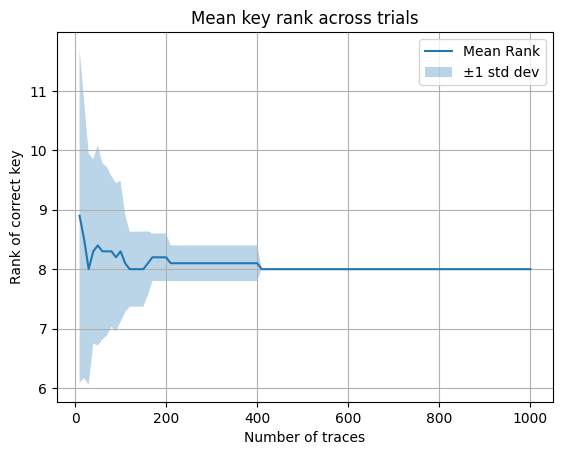

<Figure size 640x480 with 0 Axes>

In [ ]:
meta = []
for _, _, pt, key in ds_att_full.unbatch():
  k16 = np.zeros(16, np.uint8)
  k16[BYTE] = key.numpy() if key.shape==() else key.numpy()[BYTE]
  p16 = np.zeros(16, np.uint8)
  p16[BYTE] = pt.numpy() if pt.shape==() else pt.numpy()[BYTE]
  meta.append({"plaintext": p16, "key": k16})

from sca_utils import run_rank_trials, plot_mean_rank

steps, ranks = run_rank_trials(
    Pa,
    meta,
    n_traces_per_trial=min(1000, len(meta)),
    n_trials=10,
    target_byte=BYTE
)

plot_mean_rank(steps, ranks)

import matplotlib.pyplot as plt, os
out_fig = os.path.join(RUN_DIR, f"rank_attack_b{BYTE}_{MODEL}.png")
plt.savefig(out_fig, dpi=200, bbox_inches="tight")

Trials: 100%|██████████| 10/10 [04:01<00:00, 24.20s/it]


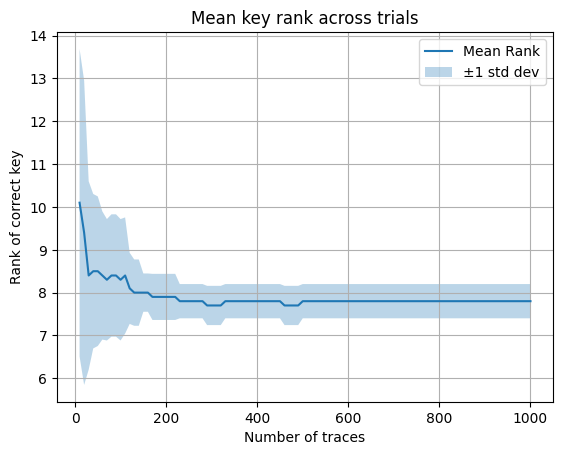

<Figure size 640x480 with 0 Axes>

In [ ]:
# Run rank eval on pure logits
steps, ranks = run_rank_trials(
    logits_a,
    meta,
    n_traces_per_trial=min(1000, len(meta)),
    n_trials=10,
    target_byte=BYTE
)

plot_mean_rank(steps, ranks)

import matplotlib.pyplot as plt, os
out_fig = os.path.join(RUN_DIR, f"logits_rank_attack_b{BYTE}_{MODEL}.png")
plt.savefig(out_fig, dpi=200, bbox_inches="tight")